In [1]:

from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))



Saving SpamTextCSV.csv to SpamTextCSV.csv
User uploaded file "SpamTextCSV.csv" with length 515223 bytes


In [56]:
# prompt: Read dataset from drive, 'Dataset_SDP.csv'

import pandas as pd
import io

df = pd.read_csv('SpamTextCSV.csv') # Assuming the file is in your MyDrive
print(df.head())

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df.columns

Index(['Category', 'Message'], dtype='object')

In [58]:
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5939 entries, 0 to 5938
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5939 non-null   object
 1   Message   5939 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


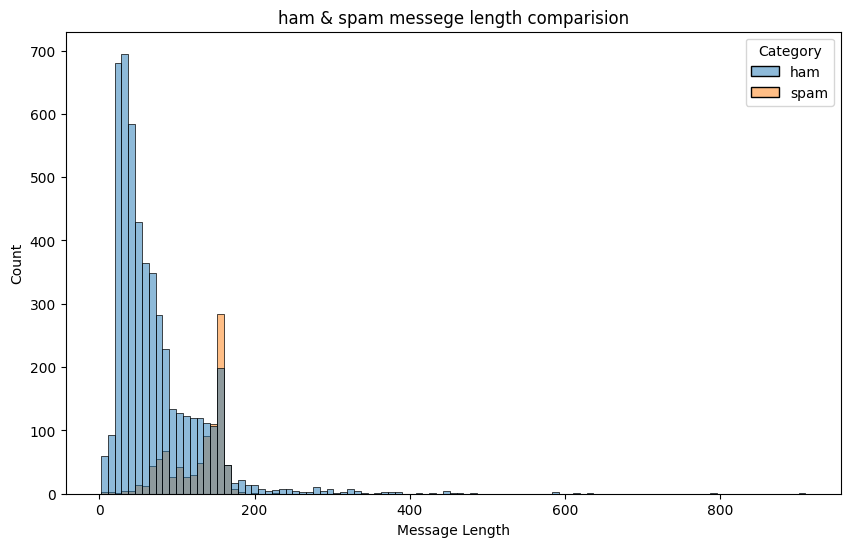

In [59]:
#extra column indicating length of message
df["Message Length"]=df["Message"].apply(len)

#figure
fig=plt.figure(figsize=(10,6))
sns.histplot(
    x=df["Message Length"],
    hue=df["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [60]:
ham_desc = df[df["Category"]=="ham"]["Message Length"].describe()
spam_desc = df[df["Category"]=="spam"]["Message Length"].describe()
print("Ham Message Length Stats")
print(ham_desc)
print("Spam Message Length Stats")
print(spam_desc)

Ham Message Length Stats
count    5015.000000
mean       71.207976
std        57.037074
min         2.000000
25%        34.000000
50%        54.000000
75%        90.000000
max       910.000000
Name: Message Length, dtype: float64
Spam Message Length Stats
count    924.000000
mean     127.110390
std       35.444228
min        7.000000
25%       97.000000
50%      143.000000
75%      156.000000
max      223.000000
Name: Message Length, dtype: float64


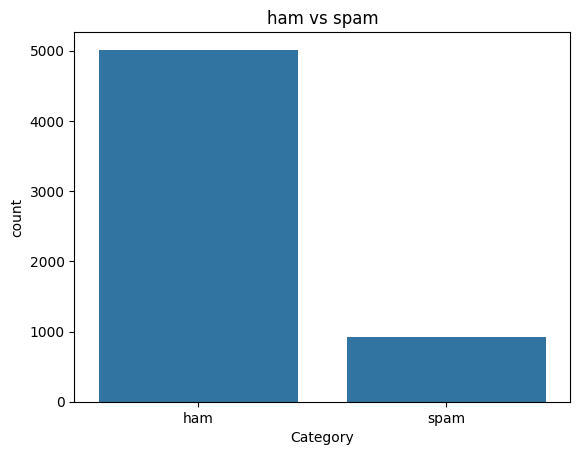

In [61]:
df["Category"].value_counts()
sns.countplot(
    data=df,
    x="Category"
)
plt.title("ham vs spam")
plt.show()

In [62]:
ham_count=df["Category"].value_counts()[0]
spam_count=df["Category"].value_counts()[1]

total_count=df.shape[0]

print("Ham contains:{:.2f}% of total data.".format(ham_count/total_count*100))
print("Spam contains:{:.2f}% of total data.".format(spam_count/total_count*100))

Ham contains:84.44% of total data.
Spam contains:15.56% of total data.


<ipython-input-62-000c1ae6ed20>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ham_count=df["Category"].value_counts()[0]
<ipython-input-62-000c1ae6ed20>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spam_count=df["Category"].value_counts()[1]


In [63]:
import numpy as np
#compute the length of majority & minority class
minority_len=len(df[df["Category"]=="spam"])
majority_len=len(df[df["Category"]=="ham"])

#store the indices of majority and minority class
minority_indices=df[df["Category"]=="spam"].index
majority_indices=df[df["Category"]=="ham"].index

#generate new majority indices from the total majority_indices
#with size equal to minority class length so we obtain equivalent number of indices length
random_majority_indices=np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)
#concatenate the two indices to obtain indices of new dataframe
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])

# print(undersampled_indices)
#create df using new indices
data=df.loc[undersampled_indices]

#shuffle the sample
data=data.sample(frac=1)

#reset the index as its all mixed
data=data.reset_index()

#drop the older index
data=data.drop(
    columns=["index"],
)

In [64]:
data["Label"]=data["Category"].map(
    {
        "ham":0,
        "spam":1
    }
)

In [65]:
data.shape
data["Category"].value_counts()

,count
Category,
ham,924
spam,924


In [66]:
data.head()

,Category,Message,Message Length,Label
0,ham,(That said can you text him one more time?),43,0
1,ham,U can call now...,17,0
2,spam,Send a logo 2 ur lover - 2 names joined by a h...,159,1
3,ham,Ok... Ur typical reply...,25,0
4,ham,Where are you ? You said you would be here whe...,62,0


In [67]:
data.shape

(1848, 4)

In [68]:
import nltk

nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [69]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer=PorterStemmer()
#declare empty list to store tokenized message
corpus=[]

#iterate through the data["Message"]
for message in data["Message"]:

    #replace every special characters, numbers etc.. with whitespace of message
    #It will help retain only letter/alphabets
    message=re.sub("[^a-zA-Z]"," ",message)

    #convert every letters to its lowercase
    message=message.lower()

    #split the word into individual word list
    message=message.split()

    #perform stemming using PorterStemmer for all non-english-stopwords
    message=[stemmer.stem(words)
            for words in message
             if words not in set(stopwords.words("english"))
            ]
    #join the word lists with the whitespace
    message=" ".join(message)

    #append the message in corpus list
    corpus.append(message)

In [70]:
corpus[0]

'said text one time'

In [71]:
newdf = pd.DataFrame({"Message":corpus,"Label":data["Label"]})

In [72]:
newdf.head()

,Message,Label
0,said text one time,0
1,u call,0
2,send logo ur lover name join heart txt love na...,1
3,ok ur typic repli,0
4,said would woke,0


In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data["Message"])
y = data["Label"]

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


              precision    recall  f1-score   support

           0       0.90      0.99      0.95       132
           1       0.99      0.90      0.95       146

    accuracy                           0.95       278
   macro avg       0.95      0.95      0.95       278
weighted avg       0.95      0.95      0.95       278



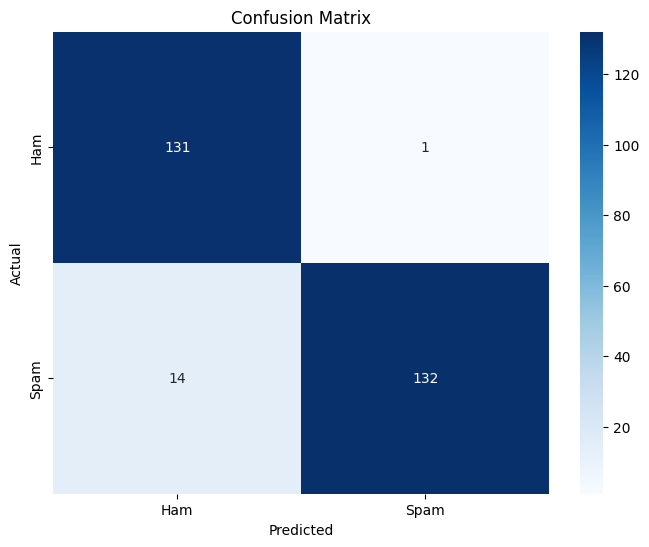

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)

y_pred = LR_model.predict(X_test)
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from your previous code

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [76]:
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, f1_score

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
recall = recall_score(y_test, y_pred, pos_label=1)
print("Recall:", recall)
precision = precision_score(y_test, y_pred, pos_label=1)
print("Precision:", precision)
f1_score = f1_score(y_test, y_pred, pos_label=1)
print("F1:", precision)


Accuracy: 0.9460431654676259
Recall: 0.9041095890410958
Precision: 0.9924812030075187
F1: 0.9924812030075187


In [77]:
# prompt: construct a function that takes the model and sentence and prints whether sentence is spam or not spam

def predict_spam(model, sentence):
    # Preprocess the input sentence
    stemmer = PorterStemmer()
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = sentence.lower()
    sentence = sentence.split()
    sentence = [stemmer.stem(word) for word in sentence if word not in set(stopwords.words("english"))]
    sentence = " ".join(sentence)

    # Vectorize the sentence
    vectorized_sentence = vectorizer.transform([sentence])

    # Make the prediction
    prediction = model.predict(vectorized_sentence)[0]

    # Print the result
    if prediction == 1:
        print("Spam")
    else:
        print("Not Spam")

In [78]:
predict_spam(LR_model, "Going for shopping to buy dress")
predict_spam(LR_model, "You won 200$!! Woahh!! email us your account number and you will get your prize money!!")
predict_spam(LR_model, "select free consult financi advisor schedul")
predict_spam(LR_model, "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030")
predict_spam(LR_model, "good to see you there, thanks for coming.")

Not Spam
Spam
Spam
Spam
Not Spam


In [80]:
# prompt: save model as joblib

import joblib

# Assuming LR_model is your trained logistic regression model
joblib.dump(LR_model, 'logistic_regression.pkl')



['logistic_regression.pkl']